# The conservative Allen-Cahn model for high Reynolds number, two phase flow with large-density and viscosity constrast

In [1]:
from pystencils.session import *
from lbmpy.session import *

from pystencils.simp import sympy_cse
from pystencils.boundaries import BoundaryHandling

from lbmpy.phasefield_allen_cahn.contact_angle import ContactAngle
from lbmpy.phasefield_allen_cahn.kernel_equations import *
from lbmpy.phasefield_allen_cahn.parameter_calculation import calculate_parameters_rti, AllenCahnParameters
from lbmpy.advanced_streaming import LBMPeriodicityHandling
from lbmpy.boundaries import NoSlip, LatticeBoltzmannBoundaryHandling

If `pycuda` is installed the simulation automatically runs on GPU

In [2]:
try:
    import pycuda
except ImportError:
    pycuda = None
    gpu = False
    target = ps.Target.CPU
    print('No pycuda installed')

if pycuda:
    gpu = True
    target = ps.Target.GPU

No pycuda installed


The conservative Allen-Cahn model (CACM) for two-phase flow is based on the work of Fakhari et al. (2017) [Improved locality of the phase-field lattice-Boltzmann model for immiscible fluids at high density ratios](http://dx.doi.org/10.1103/PhysRevE.96.053301). The model can be created for two-dimensional problems as well as three-dimensional problems, which have been described by Mitchell et al. (2018) [Development of a three-dimensional
phase-field lattice Boltzmann method for the study of immiscible fluids at high density ratios](http://dx.doi.org/10.1103/PhysRevE.96.053301). Furthermore, cascaded lattice Boltzmann methods can be combined with the model which was described in [A cascaded phase-field lattice Boltzmann model for the simulation of incompressible, immiscible fluids with high density contrast](http://dx.doi.org/10.1016/j.camwa.2019.08.018)


The CACM is suitable for simulating highly complex two phase flow problems with high-density ratios and high Reynolds numbers. In this tutorial, an overview is provided on how to derive the model with lbmpy. For this, the model is defined with two LBM populations. One for the interface tracking, which we call the phase-field LB step and one for recovering the hydrodynamic properties. The latter is called the hydrodynamic LB step.

## Geometry Setup

First of all, the stencils for the phase-field LB step as well as the stencil for the hydrodynamic LB step are defined. According to the stencils, the simulation can be performed in either 2D- or 3D-space. For 2D simulations, only the D2Q9 stencil is supported. For 3D simulations, the D3Q15, D3Q19 and the D3Q27 stencil are supported. Note here that the cascaded LBM can not be derived for D3Q15 stencils.

In [3]:
stencil_phase = LBStencil(Stencil.D2Q9)
stencil_hydro = LBStencil(Stencil.D2Q9)
assert(len(stencil_phase[0]) == len(stencil_hydro[0]))

dimensions = len(stencil_phase[0])

Definition of the domain size

In [4]:
# domain 
L0 = 256
domain_size = (L0, 4 * L0)

## Parameter definition

The next step is to calculate all parameters which are needed for the simulation. In this example, a Rayleigh-Taylor instability test case is set up. The parameter calculation for this setup is already implemented in lbmpy and can be used with the dimensionless parameters which describe the problem.

In [5]:
# time step
timesteps = 8000

# reference time
reference_time = 4000

# calculate the parameters for the RTI
parameters = calculate_parameters_rti(reference_length=L0,
                                      reference_time=reference_time,
                                      density_heavy=1.0,
                                      capillary_number=0.44,
                                      reynolds_number=3000,
                                      atwood_number=0.998,
                                      peclet_number=1000,
                                      density_ratio=1000,
                                      viscosity_ratio=100)

This function returns a `AllenCahnParameters` class. It is struct like class holding all parameters for the conservative Allen Cahn model:

In [6]:
parameters

Name,SymPy Symbol,Value
Density heavy phase,$\rho_{H}$,$1.0$
Density light phase,$\rho_{L}$,$0.001$
Relaxation time heavy phase,$\tau_{H}$,$0.0164004086170318$
Relaxation time light phase,$\tau_{L}$,$0.164004086170318$
Relaxation rate Allen Cahn LB,$\omega_{\phi}$,$1.82082623441035$
Gravitational acceleration,$F_{g}$,$-1.60320641282565 \cdot 10^{-5}$
Interface thickness,$W$,$5$
Mobility,$M_{m}$,$0.0164004086170318$
Surface tension,$\sigma$,$0.000795967692961681$


## Fields

As a next step all fields which are needed get defined. To do so, we create a `datahandling` object. More details about it can be found in the third tutorial of the [pystencils framework]( http://pycodegen.pages.walberla.net/pystencils/). This object holds all fields and manages the kernel runs.

In [7]:
# create a datahandling object
dh = ps.create_data_handling((domain_size), periodicity=(True, False), parallel=False, default_target=target)

# pdf fields. g is used for hydrodynamics and h for the interface tracking 
g = dh.add_array("g", values_per_cell=len(stencil_hydro))
dh.fill("g", 0.0, ghost_layers=True)
h = dh.add_array("h",values_per_cell=len(stencil_phase))
dh.fill("h", 0.0, ghost_layers=True)

g_tmp = dh.add_array("g_tmp", values_per_cell=len(stencil_hydro))
dh.fill("g_tmp", 0.0, ghost_layers=True)
h_tmp = dh.add_array("h_tmp",values_per_cell=len(stencil_phase))
dh.fill("h_tmp", 0.0, ghost_layers=True)

# velocity field
u = dh.add_array("u", values_per_cell=dh.dim)
dh.fill("u", 0.0, ghost_layers=True)

# phase-field
C = dh.add_array("C")
dh.fill("C", 0.0, ghost_layers=True)
C_tmp = dh.add_array("C_tmp")
dh.fill("C_tmp", 0.0, ghost_layers=True)

As a next step the relaxation time is stated in a symbolic form. It is calculated via interpolation.

In [8]:
rho_L = parameters.symbolic_density_light
rho_H = parameters.symbolic_density_heavy
density = rho_L + C.center * (rho_H - rho_L)

body_force = [0, 0, 0]
body_force[1] = parameters.symbolic_gravitational_acceleration * density

## Definition of the lattice Boltzmann methods

For both LB steps, a weighted orthogonal MRT (WMRT) method is used. It is also possible to change the method to a simpler SRT scheme or a more complicated CLBM scheme. The CLBM scheme can be obtained with `Method.CENTRAL_MOMENT`. Note here that the hydrodynamic LB step is formulated as an incompressible velocity-based LBM. Thus, the velocity terms can not be removed from the equilibrium in the central moment space.

In [9]:
w_c = parameters.symbolic_omega_phi

config_phase = LBMConfig(stencil=stencil_phase, method=Method.MRT, compressible=True,
                         delta_equilibrium=False,
                         force=sp.symbols("F_:2"), velocity_input=u,
                         weighted=True, relaxation_rates=[0, w_c, w_c, 1, 1, 1, 1, 1, 1],
                         output={'density': C_tmp}, kernel_type='stream_pull_collide')

method_phase = create_lb_method(lbm_config=config_phase)

method_phase

In [10]:
omega = parameters.omega(C)
config_hydro = LBMConfig(stencil=stencil_hydro, method=Method.MRT, compressible=False,
                         weighted=True, relaxation_rates=[omega, 1, 1, 1],
                         force=sp.symbols("F_:2"),
                         output={'velocity': u}, kernel_type='collide_stream_push')

method_hydro = create_lb_method(lbm_config=config_hydro)

method_hydro

## Initialization

The probability distribution functions (pdfs) are initialised with the equilibrium distribution for the LB methods.

In [11]:
h_updates = initializer_kernel_phase_field_lb(method_phase, C, u, h, parameters)
g_updates = initializer_kernel_hydro_lb(method_hydro, 1, u, g)

h_init = ps.create_kernel(h_updates, target=dh.default_target, cpu_openmp=True).compile()
g_init = ps.create_kernel(g_updates, target=dh.default_target, cpu_openmp=True).compile()

Following this, the phase field is initialised directly in python.

In [12]:
# initialize the domain
def Initialize_distributions():
    Nx = domain_size[0]
    Ny = domain_size[1]
    
    for block in dh.iterate(ghost_layers=True, inner_ghost_layers=False):
        x = np.zeros_like(block.midpoint_arrays[0])
        x[:, :] = block.midpoint_arrays[0]
        
        y = np.zeros_like(block.midpoint_arrays[1])
        y[:, :] = block.midpoint_arrays[1]

        y -= 2 * L0
        tmp = 0.1 * Nx * np.cos((2 * np.pi * x) / Nx)
        init_values = 0.5 + 0.5 * np.tanh((y - tmp) / (parameters.interface_thickness / 2))
        block["C"][:, :] = init_values
        block["C_tmp"][:, :] = init_values
        
    if gpu:
        dh.all_to_gpu()            
    
    dh.run_kernel(h_init, **parameters.symbolic_to_numeric_map)
    dh.run_kernel(g_init)

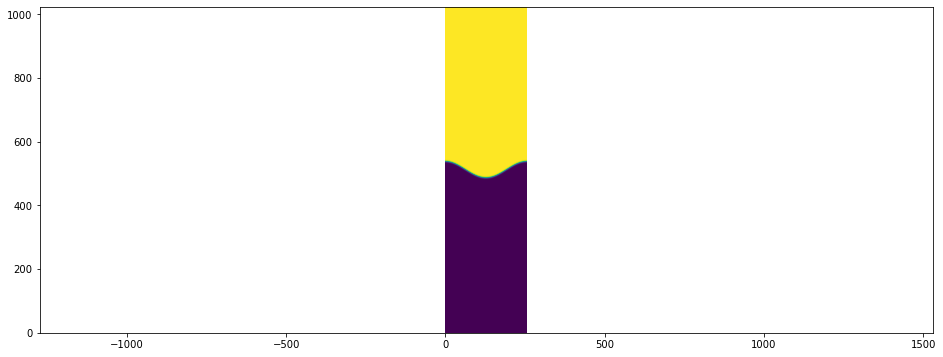

In [13]:
Initialize_distributions()
plt.scalar_field(dh.gather_array(C.name))

## Source Terms

For the Allen-Cahn LB step, the Allen-Cahn equation needs to be applied as a source term. Here, a simple forcing model is used which is directly applied in the moment space: 
$$
F_i^\phi (\boldsymbol{x}, t) = \Delta t \frac{\left[1 - 4 \left(\phi - \phi_0\right)^2\right]}{\xi} w_i \boldsymbol{c}_i \cdot \frac{\nabla \phi}{|{\nabla \phi}|},
$$
where $\phi$ is the phase-field, $\phi_0$ is the interface location, $\Delta t$ it the timestep size $\xi$ is the interface width, $\boldsymbol{c}_i$ is the discrete direction from stencil_phase and $w_i$ are the weights. Furthermore, the equilibrium needs to be shifted:

$$
\bar{h}^{eq}_\alpha = h^{eq}_\alpha - \frac{1}{2} F^\phi_\alpha
$$

The hydrodynamic force is given by:
$$
F_i (\boldsymbol{x}, t) = \Delta t w_i \frac{\boldsymbol{c}_i \boldsymbol{F}}{\rho c_s^2},
$$
where $\rho$ is the interpolated density and $\boldsymbol{F}$ is the source term which consists of the pressure force 
$$
\boldsymbol{F}_p = -p^* c_s^2 \nabla \rho,
$$
the surface tension force:
$$
\boldsymbol{F}_s = \mu_\phi \nabla \phi
$$
and the viscous force term:
$$
F_{\mu, i}^{\mathrm{MRT}} = - \frac{\nu}{c_s^2 \Delta t} \left[\sum_{\beta} c_{\beta i} c_{\beta j} \times \sum_{\alpha} \Omega_{\beta \alpha}(g_\alpha - g_\alpha^{\mathrm{eq}})\right] \frac{\partial \rho}{\partial x_j}.
$$

In the above equations $p^*$ is the normalised pressure which can be obtained from the zeroth order moment of the hydrodynamic distribution function $g$. The lattice speed of sound is given with $c_s$ and the chemical potential is $\mu_\phi$. Furthermore, the viscosity is $\nu$ and $\Omega$ is the moment-based collision operator. Note here that the hydrodynamic equilibrium is also adjusted as shown above for the phase-field distribution functions.


For CLBM methods the forcing is applied directly in the central moment space. This is done with the `CentralMomentMultiphaseForceModel`. Furthermore, the GUO force model is applied here to be consistent with [A cascaded phase-field lattice Boltzmann model for the simulation of incompressible, immiscible fluids with high density contrast](http://dx.doi.org/10.1016/j.camwa.2019.08.018). Here we refer to equation D.7 which can be derived for 3D stencils automatically with lbmpy.

In [14]:
force_h = interface_tracking_force(C, stencil_phase, parameters)
hydro_force = hydrodynamic_force(g, C, method_hydro, parameters, body_force)

## Definition of the LB update rules

The update rule for the phase-field LB step is defined as:

$$
h_i (\boldsymbol{x} + \boldsymbol{c}_i \Delta t, t + \Delta t) = h_i(\boldsymbol{x}, t) + \Omega_{ij}^h(\bar{h_j}^{eq} - h_j)|_{(\boldsymbol{x}, t)} + F_i^\phi(\boldsymbol{x}, t).
$$
In our framework the pull scheme is applied as streaming step. Furthermore, the update of the phase-field is directly integrated into the kernel. As a result of this, a second temporary phase-field is needed.

In [15]:
lbm_optimisation = LBMOptimisation(symbolic_field=h, symbolic_temporary_field=h_tmp)
allen_cahn_update_rule = create_lb_update_rule(lbm_config=config_phase,
                                               lbm_optimisation=lbm_optimisation)

allen_cahn_update_rule = add_interface_tracking_force(allen_cahn_update_rule, force_h)

ast_kernel = ps.create_kernel(allen_cahn_update_rule, target=dh.default_target, cpu_openmp=True)
kernel_allen_cahn_lb = ast_kernel.compile()

The update rule for the hydrodynmaic LB step is defined as:

$$
g_i (\boldsymbol{x} + \boldsymbol{c}_i \Delta t, t + \Delta t) = g_i(\boldsymbol{x}, t) + \Omega_{ij}^g(\bar{g_j}^{eq} - g_j)|_{(\boldsymbol{x}, t)} + F_i(\boldsymbol{x}, t).
$$

Here, the push scheme is applied which is easier due to the data access required for the viscous force term. Furthermore, the velocity update is directly done in the kernel.

In [16]:
force_Assignments = hydrodynamic_force_assignments(g, u, C, method_hydro, parameters, body_force)

lbm_optimisation = LBMOptimisation(symbolic_field=g, symbolic_temporary_field=g_tmp)
hydro_lb_update_rule = create_lb_update_rule(lbm_config=config_hydro,
                                             lbm_optimisation=lbm_optimisation)

hydro_lb_update_rule = add_hydrodynamic_force(hydro_lb_update_rule, force_Assignments, C, g, parameters)

ast_kernel = ps.create_kernel(hydro_lb_update_rule, target=dh.default_target, cpu_openmp=True)
kernel_hydro_lb = ast_kernel.compile()

## Boundary Conditions

As a last step suitable boundary conditions are applied

In [17]:
# periodic Boundarys for g, h and C
periodic_BC_C = dh.synchronization_function(C.name, target=dh.default_target, optimization = {"openmp": True})

periodic_BC_g = LBMPeriodicityHandling(stencil=stencil_hydro, data_handling=dh, pdf_field_name=g.name,
                                       streaming_pattern='push')
periodic_BC_h = LBMPeriodicityHandling(stencil=stencil_phase, data_handling=dh, pdf_field_name=h.name,
                                       streaming_pattern='pull')

# No slip boundary for the phasefield lbm
bh_allen_cahn = LatticeBoltzmannBoundaryHandling(method_phase, dh, 'h',
                                                 target=dh.default_target, name='boundary_handling_h',
                                                 streaming_pattern='pull')

# No slip boundary for the velocityfield lbm
bh_hydro = LatticeBoltzmannBoundaryHandling(method_hydro, dh, 'g' ,
                                            target=dh.default_target, name='boundary_handling_g',
                                            streaming_pattern='push')

contact_angle = BoundaryHandling(dh, C.name, stencil_hydro, target=dh.default_target)
contact = ContactAngle(90, parameters.interface_thickness)

wall = NoSlip()
if dimensions == 2:
    bh_allen_cahn.set_boundary(wall, make_slice[:, 0])
    bh_allen_cahn.set_boundary(wall, make_slice[:, -1])

    bh_hydro.set_boundary(wall, make_slice[:, 0])
    bh_hydro.set_boundary(wall, make_slice[:, -1])
    
    contact_angle.set_boundary(contact, make_slice[:, 0])
    contact_angle.set_boundary(contact, make_slice[:, -1])
else:
    bh_allen_cahn.set_boundary(wall, make_slice[:, 0, :])
    bh_allen_cahn.set_boundary(wall, make_slice[:, -1, :])

    bh_hydro.set_boundary(wall, make_slice[:, 0, :])
    bh_hydro.set_boundary(wall, make_slice[:, -1, :])
    
    contact_angle.set_boundary(contact, make_slice[:, 0, :])
    contact_angle.set_boundary(contact, make_slice[:, -1, :])


bh_allen_cahn.prepare()
bh_hydro.prepare()
contact_angle.prepare()

## Full timestep

In [18]:
# definition of the timestep for the immiscible fluids model
def timeloop():
    # Solve the interface tracking LB step with boundary conditions
    periodic_BC_h()
    bh_allen_cahn()    
    dh.run_kernel(kernel_allen_cahn_lb, **parameters.symbolic_to_numeric_map)
    dh.swap("C", "C_tmp")
    
    # apply the three phase-phase contact angle
    contact_angle()
    # periodic BC of the phase-field
    periodic_BC_C()
    
    # solve the hydro LB step with boundary conditions
    dh.run_kernel(kernel_hydro_lb, **parameters.symbolic_to_numeric_map)
    periodic_BC_g()
    bh_hydro()

    
    # field swaps
    dh.swap("h", "h_tmp")
    dh.swap("g", "g_tmp")

In [19]:
Initialize_distributions()

frames = 300
steps_per_frame = (timesteps//frames) + 1

if 'is_test_run' not in globals():
    def run():
        for i in range(steps_per_frame):
            timeloop()
            
        if gpu:
            dh.to_cpu("C")
        return dh.gather_array(C.name)

    animation = plt.scalar_field_animation(run, frames=frames, rescale=True)
    set_display_mode('video')
    res = display_animation(animation)
else:
    timeloop()
    res = None
res

Note that the video is played for 10 seconds while the simulation time is only 2 seconds!